In [50]:
import collections
import tensorflow as tf
import tensorflow_probability as tfp

from matplotlib import pyplot as plt

tfd = tfp.distributions

tfe = tf.contrib.eager

tfe.enable_eager_execution()

In [2]:
n = tfd.Normal(loc=0, scale=1)

In [9]:
n.sample()

<tf.Tensor: id=160, shape=(), dtype=float32, numpy=-0.44040918>

Can sample many times


In [14]:
n.sample(3)

<tf.Tensor: id=280, shape=(3,), dtype=float32, numpy=array([-0.61128724, -0.21337408,  0.6684134 ], dtype=float32)>

Can evaluate the probability or log probability (better for computation)

In [15]:
n.log_prob([0, 2, 4])

<tf.Tensor: id=292, shape=(3,), dtype=float32, numpy=array([-0.9189385, -2.9189386, -8.918939 ], dtype=float32)>

Can do a range of distributions, let's try a Bernoulli.

In [16]:
b = tfd.Bernoulli(probs=0.7)

In [28]:
b.sample()

<tf.Tensor: id=585, shape=(), dtype=int32, numpy=1>

In [34]:
b.sample(8)

<tf.Tensor: id=735, shape=(8,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 1, 1], dtype=int32)>

In [39]:
b.log_prob(1)

<tf.Tensor: id=811, shape=(), dtype=float32, numpy=-0.35667494>

In [40]:
b.log_prob([1, 0, 1 ,0])

<tf.Tensor: id=834, shape=(4,), dtype=float32, numpy=array([-0.35667494, -1.2039728 , -0.35667494, -1.2039728 ], dtype=float32)>

# Multivariate distributions 

create a multivariate normal with diagonal covariance.

In [42]:
nd = tfd.MultivariateNormalDiag(loc=[0, 10], scale_diag=[1, 4])

In [47]:
nd.sample(5)

<tf.Tensor: id=1167, shape=(5, 2), dtype=float32, numpy=
array([[-1.4958093 ,  2.1066437 ],
       [-1.4525412 , 12.875742  ],
       [ 1.8975519 ,  6.298768  ],
       [ 2.5066993 ,  5.384809  ],
       [ 0.58201516, 16.566956  ]], dtype=float32)>

In [48]:
nd = tfd.MultivariateNormalFullCovariance(
    loc=[0, 5], covariance_matrix = [[1, 0.7], [0.7, 1]]
)

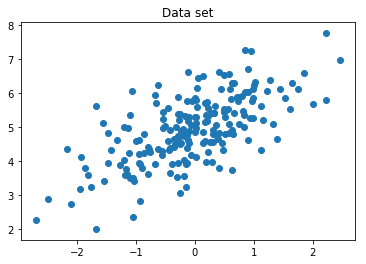

In [52]:
data = nd.sample(200)
plt.scatter(data[:, 0], data[:, 1])
plt.title("Data set")
plt.show()

# Multiple distributions

Can create a batch of independent Bernoulii distributions, each with their own parameters.

In [53]:
b3 = tfd.Bernoulli(probs=[0.3 ,0.5, 0.7])

In [70]:
b3.sample()

<tf.Tensor: id=2044, shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>

In [71]:
b3.sample(6)

<tf.Tensor: id=2069, shape=(6, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [1, 1, 0],
       [0, 1, 1],
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 1]], dtype=int32)>

Can calculate the probabilities of this set of distributions.
Remember that we usually prefer log probabilities to make computations easier.

In [72]:
b3.prob([0, 0, 0])

<tf.Tensor: id=2086, shape=(3,), dtype=float32, numpy=array([0.7, 0.5, 0.3], dtype=float32)>

# Using `Independent` to aggregate batches to events

Using the `Independent` distribution we can collect different independent, non-identical distributions into a single random variable.

We can use this to make a joint distribution from the Bernoulli distribution above, where calling the `prob` on the vector will return a single value representing the probability that the entire set of coins matches the vector.


In [73]:
b3_joint = tfd.Independent(b3, reinterpreted_batch_ndims=1)

In [79]:
b3_joint.prob([1, 1 , 0])

<tf.Tensor: id=2287, shape=(), dtype=float32, numpy=0.044999998>

A different way to get the same result would be to calculate the independent probabilities using `b3` and then reducing them down using multiplication (or more usually by taking the sum of the log probabilities)

In [80]:
tf.reduce_prod(b3.prob([1, 1 ,0]))

<tf.Tensor: id=2305, shape=(), dtype=float32, numpy=0.045>

# Batches of multivariate distributions 

Let's create a batch of three full-covariance 2D multivariate normals:



In [82]:
nd_batch = tfd.MultivariateNormalFullCovariance(
    loc = [
        [0, 0],
        [1, 1],
        [2, 2]
    ],
    covariance_matrix = [
        [
            [1, .1], [.1, 1]
        ],
        [
            [1, .3], [.3, 1]
        ],
        [
            [1., .5], [.5, 1]
        ]
    ]
)

nd_batch

<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance/' batch_shape=(3,) event_shape=(2,) dtype=float32>

In [83]:
nd_batch.sample(4)

<tf.Tensor: id=2582, shape=(4, 3, 2), dtype=float32, numpy=
array([[[-0.68187916,  0.88921064],
        [ 0.37704998,  2.2577877 ],
        [ 1.0307043 ,  1.15323   ]],

       [[ 1.3254962 , -1.9494101 ],
        [ 0.6303658 ,  1.3965571 ],
        [ 1.2425237 ,  1.6790835 ]],

       [[ 1.447411  , -0.33083546],
        [ 0.6236936 ,  0.6541339 ],
        [-0.24466681,  0.7171593 ]],

       [[ 1.0029824 ,  0.6290948 ],
        [ 0.67543066, -0.43360674],
        [ 2.3666031 ,  2.6393032 ]]], dtype=float32)>

In [84]:
nd_batch

<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance/' batch_shape=(3,) event_shape=(2,) dtype=float32>

Since the batch shape is 3 and the event shape is 2, we can pass it a tensor of shape (3, 2) to get a log probability.


In [85]:
nd_batch.log_prob([[0, 0], [1, 1], [2, 2]])

<tf.Tensor: id=2632, shape=(3,), dtype=float32, numpy=array([-1.8328519, -1.7907217, -1.694036 ], dtype=float32)>